AK.CHN..BNE | 2021-07-29T06:14:47.008400Z - 2021-07-29T06:19:47.008400Z | 50.0 Hz, 15001 samples
AK.CHN..BNN | 2021-07-29T06:14:47.008400Z - 2021-07-29T06:19:47.008400Z | 50.0 Hz, 15001 samples
AK.CHN..BNZ | 2021-07-29T06:14:47.008400Z - 2021-07-29T06:19:47.008400Z | 50.0 Hz, 15001 samples
AK.CHN..BNE | 2021-07-29T06:14:47.008400Z - 2021-07-29T06:19:47.008400Z | 50.0 Hz, 15001 samples
AK.CHN..BNN | 2021-07-29T06:14:47.008400Z - 2021-07-29T06:19:47.008400Z | 50.0 Hz, 15001 samples
AK.CHN..BNZ | 2021-07-29T06:14:47.008400Z - 2021-07-29T06:19:47.008400Z | 50.0 Hz, 15001 samples
3 Trace(s) in Stream:
AK.CHN..BNE | 2021-07-29T06:14:47.000000Z - 2021-07-29T06:19:47.000000Z | 1.0 Hz, 301 samples
AK.CHN..BNN | 2021-07-29T06:14:47.000000Z - 2021-07-29T06:19:47.000000Z | 1.0 Hz, 301 samples
AK.CHN..BNZ | 2021-07-29T06:14:47.000000Z - 2021-07-29T06:19:47.000000Z | 1.0 Hz, 301 samples


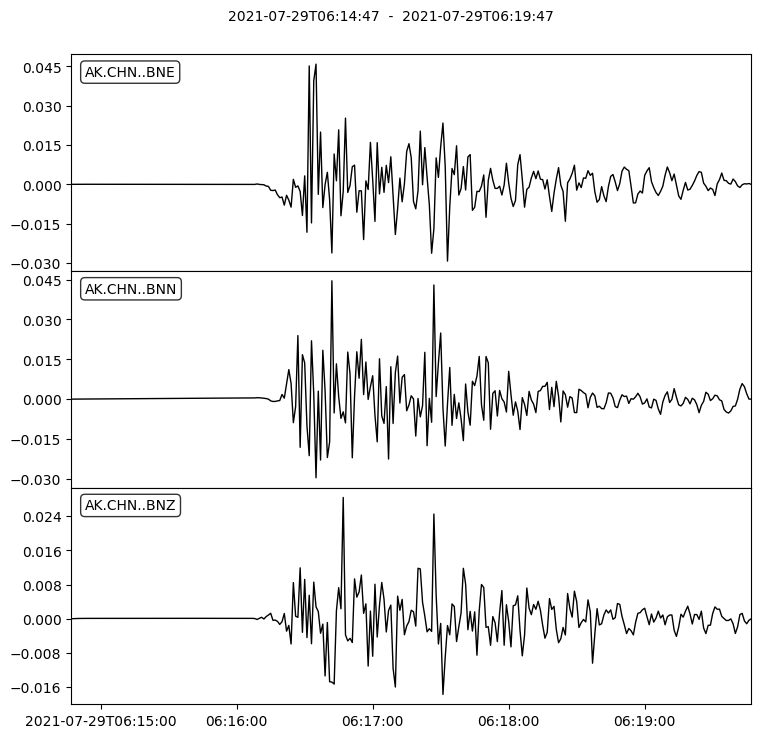

In [53]:
######## GNSS instavel Vs strong-motion derived velocity analysis and plots ##################
################################## Scipy version #############################################
####################################### Goals ################################################
#     1) Read a GNSS instavel and convert it into an obspy stream
#     2) Filter instavel
#     3) Load acceleration from IRIS client
#     4) Filter and integrate strong-motion acceleration to corresponding velocity
#     5) Subtract/find difference between GNSS and strong motion veocity
#     6) Subtract the difference from GNSS and plot trace
#     7) cross-correlate and plot both versions
##############################################################################################

from obspy import UTCDateTime 				
from obspy import Trace
from obspy import Stream
from obspy import read_inventory
from obspy.clients.fdsn import Client 		
client=Client("IRIS")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# LOAD ONE SEISMIC ACCELERATION STREAM FROM IRIS DMC
start = UTCDateTime("2021-07-29T06:14:47.008400Z")
st_seis_a = client.get_waveforms('AK', 'CHN', "*", 'BN*', (start), (start+300), attach_response=True)
#st_seis_ae[0].plot()
print(st_seis_a[0])
print(st_seis_a[1])
print(st_seis_a[2])

# TIDY UP ACCELERATION TRACE
index = [0,1,2]
for i in index:
    st_seis_a[i].remove_response(inventory=None, output="ACC", plot=False)
    st_seis_a[i].detrend('linear')
    st_seis_a[i].detrend('demean')
#    st_seis_a[i].filter('bandpass', freqmin=0.001, freqmax=0.499, corners=4, zerophase=True)


# CREATE A SEISMIC VELOCITY TRACE
st_seis_ve = st_seis_a[0].copy()
st_seis_ve.integrate(method='cumtrapz')
hze = st_seis_ve.data[::50]   # Brute-force 'downsampling' of strong-motion derived velocity to 1 Hz post-filtering and -integration
st_seis_ve.filter('bandpass', freqmin=0.001, freqmax=0.25, corners=4, zerophase=True)
st_seis_vn = st_seis_a[1].copy()
st_seis_vn.integrate(method='cumtrapz')
hzn = st_seis_vn.data[::50]
st_seis_vz = st_seis_a[2].copy()
st_seis_vz.integrate(method='cumtrapz')
hzz = st_seis_vz.data[::50]
print(st_seis_ve)
print(st_seis_vn)
print(st_seis_vz)
#st_seis_ve.plot()
#print(st_seis_ve.max())

# CREATE AN st_sm_vEMPTY STREAM AND POPULATE WITH 1Hz STRONG-MOTION DERIVED VELOCITY DATA
st_sm_ve = Trace()
st_sm_ve.stats.network = 'AK'
st_sm_ve.stats.station = 'CHN'
st_sm_ve.stats.channel = 'BNE'    
st_sm_ve.stats.starttime = UTCDateTime("2021-07-29T06:14:47.0Z")
st_sm_ve.stats.sampling_rate = 1
st_sm_ve.stats.calib = 1
st_sm_ve.data = hze
st_sm_vn = Trace()
st_sm_vn.stats.network = 'AK'
st_sm_vn.stats.station = 'CHN'
st_sm_vn.stats.channel = 'BNN'    
st_sm_vn.stats.starttime = UTCDateTime("2021-07-29T06:14:47.0Z")
st_sm_vn.stats.sampling_rate = 1
st_sm_vn.stats.calib = 1
st_sm_vn.data = hzn
st_sm_vz = Trace()
st_sm_vz.stats.network = 'AK'
st_sm_vz.stats.station = 'CHN'
st_sm_vz.stats.channel = 'BNZ'    
st_sm_vz.stats.starttime = UTCDateTime("2021-07-29T06:14:47.0Z")
st_sm_vz.stats.sampling_rate = 1
st_sm_vz.stats.calib = 1
st_sm_vz.data = hzz
st_sm_v = Stream(traces=[st_sm_ve, st_sm_vn, st_sm_vz])
print(st_sm_v)
t = UTCDateTime("2021-07-29T06:15:47.000000Z")
tt = st_sm_ve.times()
#dt = tt - t
# CREATE STREAMS WITH ALL TRACES AND PLOT THEM
st = Stream([st_sm_ve, st_sm_vn, st_sm_vz])
st.plot(equal_scale=False, automerge=False)

pd.concat([pd.DataFrame(tt), pd.DataFrame(hzn), pd.DataFrame(hze), pd.DataFrame(hzz)], axis=1).to_csv('CHN.csv')
